<a href="https://colab.research.google.com/github/ftxsilva/PIE-33/blob/master/SVM_for_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM for Outlier Detection

## Google Colab stuff


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import io
import collections
from sklearn.model_selection import train_test_split

dataframe =  pd.read_csv('/content/drive/My Drive/PIE - 33/Détection d\'Anomalies/Data_Anomaly.csv', sep=',',decimal=b'.')
dataframe.head()

,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Min,E24E25E37 IntercalaireFroid hauteur apres calibrage droit,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Max,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Min,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche Min,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Max,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Min,E24E25E37 IntercalaireFroid hauteur sorti formage droit,E24E25E37 IntercalaireFroid hauteur sorti formage droit Max,E24E25E37 IntercalaireFroid hauteur sorti formage droit Min,E24E25E37 IntercalaireFroid hauteur sorti formage gauche,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Max,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Min,E24E25E37 IntercalaireFroid hauteur sorti formage milieu,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Max,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Min,E24E25E37 IntercalaireFroid largeur de bande,E24E25E37 IntercalaireFroid largeur de bande Max,E24E25E37 IntercalaireFroid largeur de bande Min,E24E25E37 IntercalaireFroid largeur de passe (longueur),E24E25E37 IntercalaireFroid largeur de passe (longueur) Min,E24E25E37 IntercalaireFroid pic et creux local dessous,E24E25E37 IntercalaireFroid pic et creux local dessous Max,E24E25E37 IntercalaireFroid pic et creux local dessous Min,E24E25E37 IntercalaireFroid pic et creux local dessus,E24E25E37 IntercalaireFroid pic et creux local dessus Max,E24E25E37 IntercalaireFroid pic et creux local dessus Min,E42 Hauteur du faisceau comprimé,E45E35E36 P < 6.6 10-5mbar 1,E45E35E36 P < 6.6 10-5mbar 2,E45E35E36 Relevé le temps de pompage,E49 Hauteur maximale,E49 Hauteur minimale,E49 Masse <=15.3kg,E49 Perpendicularité passe chaude,E49 Perpendicularité passe froide,E66 valeur de fuite premier essai,E29 IntercalaireFroid,"E24E25E37 IntercalaireFroid Controle visuel avec la boite a lumiere : absence de perforation, dechirement plus particulierement sur les zones de frippage-0",E24E25E37 IntercalaireFroid Noter le numero du centre de charge de la machine utilisee (E24-E25-E37)-E24E25,E24E25E37 IntercalaireFroid Noter le numero du centre de charge de la machine utilisee (E24-E25-E37)-E25E37,E24E25E37 IntercalaireFroid Noter le numero du centre de charge de la machine utilisee (E24-E25-E37)-E37,E45E35E36 588°C < T° palier de brasage < 600°C-NOK,E45E35E36 Four-E35,E45E35E36 Nombre de faisceaux de la fournée-4,E45E35E36 Nombre de faisceaux de la fournée-6,E45E35E36 Nombre de faisceaux de la fournée-8,E45E35E36 Position-Position 1,E45E35E36 Position-Position 2,E45E35E36 Position-Position 3,E45E35E36 Position-Position 4,E45E35E36 Position-Position 5,E45E35E36 Position-Position 6,E45E35E36 Position-Position 7,E45E35E36 Position-Position 8,E45E35E36 n° de cycle et n° de version-4035,E49 Contrôle visuel suivant MFT n°408-NOK,E66 nombre de retouches après le premier essai
0,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,645,0.000028,0.00004,100,637.510010,636.989990,14.78,1.4,2.5,0.1,513236,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0
1,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,645,0.000028,0.00004,100,637.659973,637.309998,14.80,1.1,1.1,0.1,513236,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0
2,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.0

## Get float values

In [ ]:
for name in dataframe.columns:
    l = np.array(dataframe[name])
    if len(collections.Counter(l)) == 1:
        dataframe.drop(name,1, inplace = True)

print('Unique types of variables: ', dataframe.dtypes.unique())
floats = dataframe.select_dtypes('float64')
categories = dataframe.select_dtypes('O')
ints = dataframe.select_dtypes('int64')

len(categories.columns) + len(floats.columns) == len(dataframe.columns)
print('# of columns: ', len(dataframe.columns))
print('# of Categorical columns: ', len(categories.columns))
print('# of Float columns: ', len(floats.columns))
print('# of Int columns: ', len(ints.columns))
floats.head()

Unique types of variables:  [dtype('float64') dtype('int64')]
# of columns:  62
# of Categorical columns:  0
# of Float columns:  39
# of Int columns:  23


,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Min,E24E25E37 IntercalaireFroid hauteur apres calibrage droit,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Max,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Min,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche Min,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Max,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Min,E24E25E37 IntercalaireFroid hauteur sorti formage droit,E24E25E37 IntercalaireFroid hauteur sorti formage droit Max,E24E25E37 IntercalaireFroid hauteur sorti formage droit Min,E24E25E37 IntercalaireFroid hauteur sorti formage gauche,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Max,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Min,E24E25E37 IntercalaireFroid hauteur sorti formage milieu,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Max,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Min,E24E25E37 IntercalaireFroid largeur de bande,E24E25E37 IntercalaireFroid largeur de bande Max,E24E25E37 IntercalaireFroid largeur de bande Min,E24E25E37 IntercalaireFroid largeur de passe (longueur),E24E25E37 IntercalaireFroid largeur de passe (longueur) Min,E24E25E37 IntercalaireFroid pic et creux local dessous,E24E25E37 IntercalaireFroid pic et creux local dessous Max,E24E25E37 IntercalaireFroid pic et creux local dessous Min,E24E25E37 IntercalaireFroid pic et creux local dessus,E24E25E37 IntercalaireFroid pic et creux local dessus Max,E24E25E37 IntercalaireFroid pic et creux local dessus Min,E45E35E36 P < 6.6 10-5mbar 1,E45E35E36 P < 6.6 10-5mbar 2,E49 Hauteur maximale,E49 Hauteur minimale,E49 Masse <=15.3kg,E49 Perpendicularité passe chaude,E49 Perpendicularité passe froide,E66 valeur de fuite premier essai
0,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,0.000028,0.00004,637.510010,636.989990,14.78,1.4,2.5,0.1
1,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,0.000028,0.00004,637.659973,637.309998,14.80,1.1,1.1,0.1
2,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,0.000028,0.00004,637.400024,637.080017,14.78,2.0,2.5,1.3
3,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,0.000028,0.00004,637.090027,636.719971,14.79,1.0,1.4,0.1
4,257.957143,259.0,255.0,10.969843,10.98,10.95,10.964994,10.95,10.968014,10.98,10.95,11.04175,11.045,11.037,11.044,11.045,11.041,11.0055,11.009,11.001,178.752499,178.759995,178.75,281.99157,279.799988,0.032871,0.056,0.012,0.0294,0.049,0.012,0.000028,0.00004,637.309998,637.289978,14.79,1.1,1.3,1.7


### Training-Test Split et Classification des données

In [ ]:
'''
    Training data
'''
# Selecting float dataset
df = floats.iloc[:,:-1]
vec = floats.iloc[:,-1].values
defect = vec > 20 # arbitrary choice
df_defect = pd.DataFrame(defect, columns=['Classification']).astype('uint8')

# Normalizing
x = df
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

X = pd.DataFrame(x_scaled, columns=x.columns)
y = df_defect.to_numpy()
X.head()

,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max,E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Min,E24E25E37 IntercalaireFroid hauteur apres calibrage droit,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Max,E24E25E37 IntercalaireFroid hauteur apres calibrage droit Min,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche,E24E25E37 IntercalaireFroid hauteur apres calibrage gauche Min,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Max,E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Min,E24E25E37 IntercalaireFroid hauteur sorti formage droit,E24E25E37 IntercalaireFroid hauteur sorti formage droit Max,E24E25E37 IntercalaireFroid hauteur sorti formage droit Min,E24E25E37 IntercalaireFroid hauteur sorti formage gauche,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Max,E24E25E37 IntercalaireFroid hauteur sorti formage gauche Min,E24E25E37 IntercalaireFroid hauteur sorti formage milieu,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Max,E24E25E37 IntercalaireFroid hauteur sorti formage milieu Min,E24E25E37 IntercalaireFroid largeur de bande,E24E25E37 IntercalaireFroid largeur de bande Max,E24E25E37 IntercalaireFroid largeur de bande Min,E24E25E37 IntercalaireFroid largeur de passe (longueur),E24E25E37 IntercalaireFroid largeur de passe (longueur) Min,E24E25E37 IntercalaireFroid pic et creux local dessous,E24E25E37 IntercalaireFroid pic et creux local dessous Max,E24E25E37 IntercalaireFroid pic et creux local dessous Min,E24E25E37 IntercalaireFroid pic et creux local dessus,E24E25E37 IntercalaireFroid pic et creux local dessus Max,E24E25E37 IntercalaireFroid pic et creux local dessus Min,E45E35E36 P < 6.6 10-5mbar 1,E45E35E36 P < 6.6 10-5mbar 2,E49 Hauteur maximale,E49 Hauteur minimale,E49 Masse <=15.3kg,E49 Perpendicularité passe chaude,E49 Perpendicularité passe froide
0,0.841316,0.75,1.0,0.680382,1.0,0.526326,0.407519,0.624985,0.644343,1.0,0.55555,0.808333,0.613207,0.969998,0.783506,0.513271,1.0,0.636363,0.513888,0.728573,0.396468,0.199991,0.721159,0.367717,0.871787,0.508005,0.4375,0.466667,0.446054,0.475,0.411765,0.216867,0.177215,0.411514,0.465033,0.78,0.350,0.625
1,0.841316,0.75,1.0,0.680382,1.0,0.526326,0.407519,0.624985,0.644343,1.0,0.55555,0.808333,0.613207,0.969998,0.783506,0.513271,1.0,0.636363,0.513888,0.728573,0.396468,0.199991,0.721159,0.367717,0.871787,0.508005,0.4375,0.466667,0.446054,0.475,0.411765,0.216867,0.177215,0.466126,0.576922,0.80,0.275,0.275
2,0.841316,0.75,1.0,0.680382,1.0,0.526326,0.407519,0.624985,0.644343,1.0,0.55555,0.808333,0.613207,0.969998,0.783506,0.513271,1.0,0.636363,0.513888,0.728573,0.396468,0.199991,0.721159,0.367717,0.871787,0.508005,0.4375,0.466667,0.446054,0.475,0.411765,0.216867,0.177215,0.371460,0.496511,0.78,0.500,0.625
3,0.841316,0.75,1.0,0.680382,1.0,0.526326,0.407519,0.624985,0.644343,1.0,0.55555,0.808333,0.613207,0.969998,0.783506,0.513271,1.0,0.636363,0.513888,0.728573,0.396468,0.199991,0.721159,0.367717,0.871787,0.508005,0.4375,0.466667,0.446054,0.475,0.411765,0.216867,0.177215,0.258569,0.370623,0.79,0.250,0.350
4,0.841316,0.75,1.0,0.680382,1.0,0.526326,0.407519,0.624985,0.644343,1.0,0.55555,0.808333,0.613207,0.969998,0.783506,0.513271,1.0,0.636363,0.513888,0.728573,0.396468,0.199991,0.721159,0.367717,0.871787,0.508005,0.4375,0.466667,0.446054,0.475,0.411765,0.216867,0.177215,0.338675,0.569923,0.79,0.275,0.325


### Train test split

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=.2, random_state = 1)

### Diviser les parties bonnes des parties mauvaises

In [ ]:
[train_X_0, train_X_1, train_y_0, train_y_1, val_y_0, val_y_1] = \
    [train_X[train_y==0].copy(), train_X[train_y==1].copy(), \
    train_y[train_y==0].copy(), train_y[train_y==1].copy(),\
     val_y[val_y==0].copy(), val_y[val_y==1].copy()]

## One Class SVM


Detecter les anomalies dans le dataset entier, apres regarder chaque variable individuellement. 

* **nu**: proportion d'outliers j'estime a observer
* **gamma**: parameter qui determine le 'smoothing' de contour lines

## Approach #1

In [ ]:
train_normal = train_y_0
train_outliers = train_y_1
outlier_prop = len(train_outliers) /( len(train_outliers)+len(train_normal) )
print('Proportion of outliers: %.2f '% outlier_prop)

Proportion of outliers: 0.09 


Fitting

In [ ]:
from sklearn.svm import OneClassSVM 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001)
svm.fit(train_X_0)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-06, kernel='rbf',
            max_iter=-1, nu=0.09141940657578188, shrinking=True, tol=0.001,
            verbose=False)

Predicting

In [ ]:
y_pred = svm.predict(val_X)

Plotting pour chaque variable

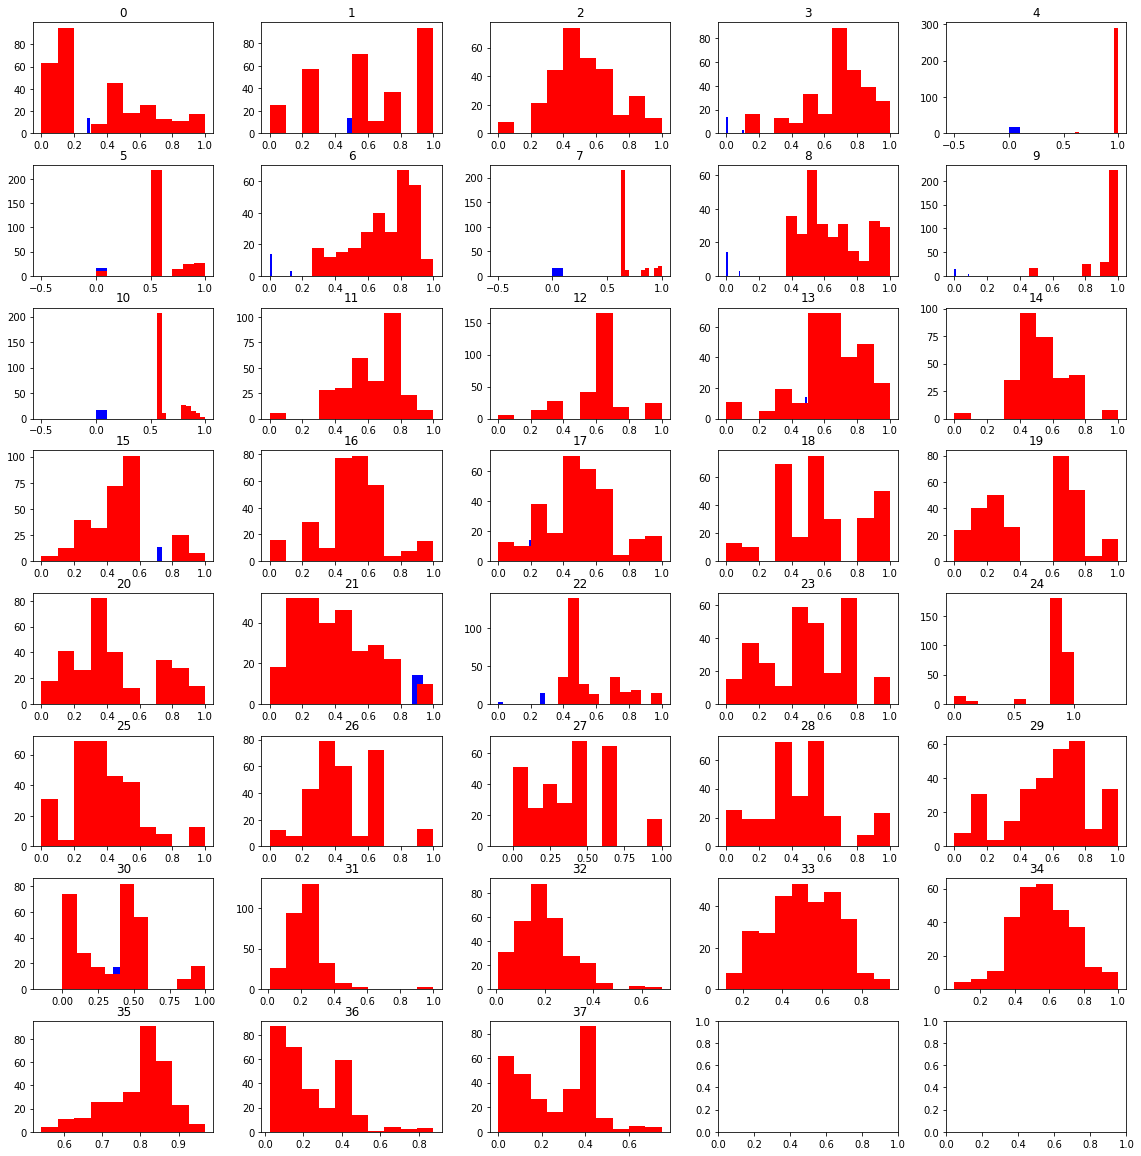

In [ ]:
fig, ax = plt.subplots(8,5, figsize = [16,16])
fig.tight_layout()
counter = 0
colors = np.array(['#377eb8', '#ff7f00'])
y_pred = svm.predict(val_X)
for i in range(8):
    for j in range(5):
        if counter <= 37:
            x1 = val_X[y_pred==-1].iloc[:,counter]
            x2 = val_X[y_pred==1].iloc[:,counter]
            ax[i][j].hist(x1, color='b')
            ax[i][j].hist(x2, color='r')
            ax[i][j].set_title(counter)
        counter += 1

## Approach #2

Fitting, Predicting and Ploting chaque variable

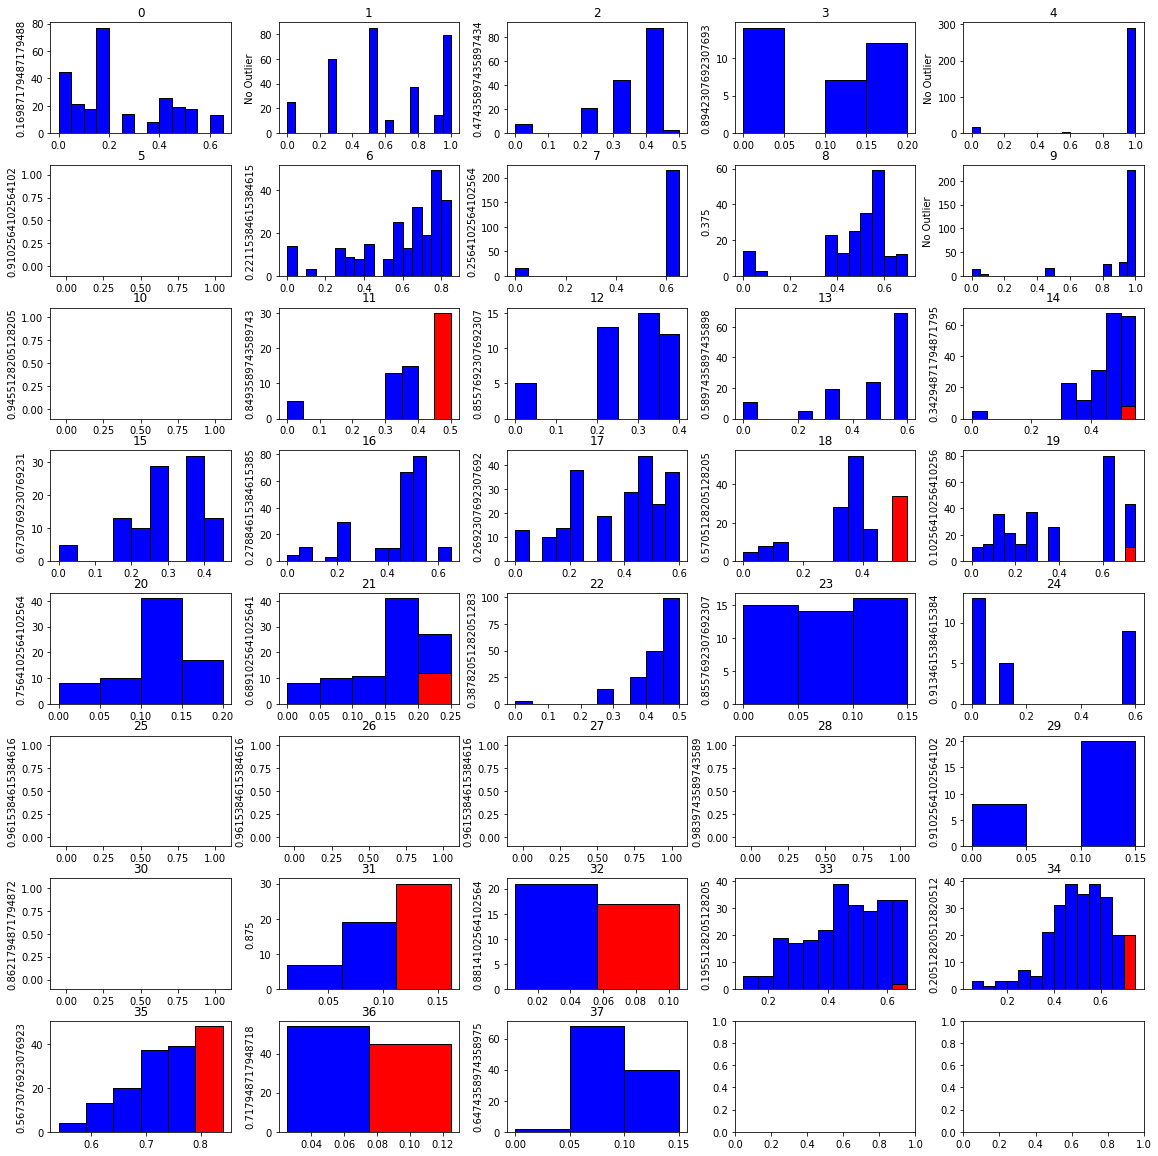

In [ ]:
fig, ax = plt.subplots(8,5, figsize = [16,16])
fig.tight_layout()
investigate_feature = []
err = []
counter = 0
colors = np.array(['#377eb8', '#ff7f00'])
# Training set
train_normal = train_y_0
train_outliers = train_y_1
outlier_prop = len(train_outliers) /( len(train_outliers)+len(train_normal) )
outlier_prop = 0.001
for i in range(8):
    for j in range(5):
        if counter <= 37:
            # Fitting
            svm = OneClassSVM(kernel='poly', nu=outlier_prop, gamma=0.000001)
            svm.fit(train_X_0.iloc[:,counter].to_numpy().reshape(-1,1))
            # Predicting
            y_pred = svm.predict(val_X.iloc[:,counter].to_numpy().reshape(-1,1))
            if (np.sum(y_pred==1)/(len(y_pred)) > 0.3):
                investigate_feature.append(counter)
            #Plotting
            x1 = val_X[y_pred==-1].iloc[:,counter]
            x2 = val_X[y_pred==1].iloc[:,counter]
            err.append((y_pred+1)/2 != val_y.reshape(-1))
            binwidth = 0.05
            ax[i][j].hist(x1, color='b', bins=np.arange(min(x1), max(x1) + binwidth, binwidth), edgecolor='k')
            ax[i][j].hist(x2, color='r', bins=np.arange(min(x1), max(x1) + binwidth, binwidth), edgecolor='k')
            ax[i][j].set_title(counter)
            if np.size(x2) > 0:
                ax[i][j].set_ylabel(np.size(x2)/(np.size(x2)+np.size(x1)))
            else: 
                ax[i][j].set_ylabel('No Outlier')
        counter += 1

In [ ]:
investigate = np.sum(err, axis=1)/len(val_y)
print(investigate)
investigate_decision = np.sum(err, axis=1)/len(val_y) < 0.2

[0.25       0.08653846 0.50961538 0.8974359  0.08653846 0.91346154
 0.27564103 0.31089744 0.42307692 0.08653846 0.94230769 0.83333333
 0.76923077 0.58012821 0.33333333 0.65064103 0.28846154 0.32371795
 0.57371795 0.18269231 0.78525641 0.63461538 0.44230769 0.8525641
 0.82692308 0.875      0.875      0.875      0.8974359  0.82371795
 0.80128205 0.78846154 0.79487179 0.27564103 0.28525641 0.52564103
 0.66346154 0.59294872]


Dictionary of variable values

In [ ]:
var_num = investigate_decision
var_name = X.columns[var_num]
print(var_name)

Index(['E24E25E37 IntercalaireFroid Longueur Mesuree LM/100plis Max',
       'E24E25E37 IntercalaireFroid hauteur apres calibrage droit Max',
       'E24E25E37 IntercalaireFroid hauteur apres calibrage milieu Max',
       'E24E25E37 IntercalaireFroid hauteur sorti formage milieu Min'],
      dtype='object')
